In [318]:
import openpyxl as op
import urllib.request as req
import xml.etree.ElementTree as ET
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import os
from pprint import pprint

DATA_PATH = "../data"
XML_SCHEMAS = {
    'R2.0.9.S03.E01' : "{http://publications.europa.eu/resource/schema/ted/R2.0.9/publication}",
    'R2.0.9.S04.E01' : "{http://publications.europa.eu/resource/schema/ted/R2.0.9/publication}",
    'R2.0.9.S02.E01' : "{ted/R2.0.9.S02/publication}",
    'R2.0.9.S01.E01' : "{http://formex.publications.europa.eu/ted/schema/export/R2.0.9.S01.E01}",
    None : "{http://publications.europa.eu/TED_schema/Export}"
}
LOG_MODE = False

### Downloading contracts

NOTE: This isn't neccessary anymore. There is a different way to download all frontex tender award notices in bulk from the TED website. See notes doc.

In [ ]:
# download all frontex contracts referenced in sheets
doc_history = set()
contract_counter = 0
for sheet_file in os.listdir(DATA_PATH + "/sheets/"):
    wb = op.load_workbook(DATA_PATH + "/sheets/" + sheet_file)
    sheet = wb.active
    
    # download all contracts in XML format
    for row in sheet.rows:
        if "frontex" in row[3].value.lower() or "border" in row[3].value.lower():
            url = row[0].hyperlink.target.replace(":TEXT:", ":XML:")
            doc_id = url.split(":")[3]
            
            if doc_id not in doc_history:
                # add document to history
                doc_history.add(doc_id)
            
                # download document
                try:
                    req.urlretrieve(url, DATA_PATH + "/XML/" + doc_id + ".xml")
                    if LOG_MODE: print(f"Saved {row[2].value} to {doc_id}.xml")
                except Exception as E:
                    print(E)

                contract_counter += 1

### Extracting data from XML documents

In [ ]:
# Lets explore a contract!
contract = "309706-2014.xml"
xml_tree = ET.parse(DATA_PATH + "/XML/" + contract)
schema = XML_SCHEMAS[xml_tree.getroot().attrib.get('VERSION')]
FORM_SECTION = xml_tree.getroot().find(schema + "FORM_SECTION")[2][0]
OBJECT_CONTRACT = FORM_SECTION.find(schema + "OBJECT_CONTRACT_INFORMATION_CONTRACT_AWARD_NOTICE")
OBJECT_DESCR = OBJECT_CONTRACT.find(schema + "DESCRIPTION_AWARD_NOTICE_INFORMATION")
AWARD_OF_CONTRACT = FORM_SECTION.findall(schema + "AWARD_OF_CONTRACT")
COSTS_RANGE_AND_CURRENCY_WITH_VAT_RATE = AWARD_OF_CONTRACT[1].find(schema + "CONTRACT_VALUE_INFORMATION").find(schema + "COSTS_RANGE_AND_CURRENCY_WITH_VAT_RATE")
VALUE_COST = COSTS_RANGE_AND_CURRENCY_WITH_VAT_RATE.find(schema + "VALUE_COST")

temp = AWARD_OF_CONTRACT[0].find(schema + "ECONOMIC_OPERATOR_NAME_ADDRESS").find(schema + "CONTACT_DATA_WITHOUT_RESPONSIBLE_NAME").find(schema + "ORGANISATION").find(schema + "OFFICIALNAME").text
pprint(temp)
pprint(list(temp))

In [317]:
data = pd.DataFrame(columns=["Contract", "Title", "Type of contract", "Short description", "Total value", "Place of performance", "Contractor"])

# Reasons for skipping:
#     - different spellings of Lot no, TODO: handle these exceptions
#     - Different overall form structure
error_counter = {
    "Cannot find FORM_SECTION" : 0,
    "Cannot find OBJECT_CONTRACT" : 0,
    "Cannot find LOT_NO in award section": 0,
    "Missing place of performance" : 0,
    "Missing value" : 0,
    "Missing contractor" : 0
}
contract_counter, fail_counter = 0, 0
skip = ['185944-2018.xml', '245168-2020.xml', '509257-2018.xml', '019628-2016.xml', '412856-2017.xml']
for contract in os.listdir(DATA_PATH + "/XML/"):
    if contract in skip:
        fail_counter += 1
        continue
        
    if LOG_MODE: print(f"Extracting data: {contract}")
    
    # parse the XML structure
    xml_tree = ET.parse(DATA_PATH + "/XML/" + contract)
    VERSION = xml_tree.getroot().attrib.get('VERSION')
    old_version = VERSION is None
    schema = XML_SCHEMAS[VERSION]
    
    # the english translation of the form
    FORM_SECTION = xml_tree.getroot().find(schema + "FORM_SECTION")
    if FORM_SECTION is None:
        if LOG_MODE: print("    Cannot find FORM_SECTION")
        error_counter["Cannot find FORM_SECTION"] += 1
        fail_counter += 1
        continue
        
    if old_version:
        FORM_SECTION = FORM_SECTION[2][0]
    else:
        FORM_SECTION = FORM_SECTION[2]        

    # the object description section(s)
    query = "OBJECT_CONTRACT_INFORMATION_CONTRACT_AWARD_NOTICE" if old_version else "OBJECT_CONTRACT"
    OBJECT_CONTRACT = FORM_SECTION.find(schema + query)
    if OBJECT_CONTRACT is None:
        if LOG_MODE: print("    Cannot find OBJECT_CONTRACT")
        error_counter["Cannot find OBJECT_CONTRACT"] += 1
        fail_counter += 1
        continue
        
    query = "DESCRIPTION_AWARD_NOTICE_INFORMATION" if old_version else "OBJECT_DESCR"
    OBJECT_DESCR = OBJECT_CONTRACT.findall(schema + query) 
    
    # find out if divided into lots and if so save multiple object descriptions
    # old version are never divided into lots
    has_lots = not old_version and OBJECT_CONTRACT.find(schema + "LOT_DIVISION") is not None
    if has_lots:
        lot_dict = {int(desc.find(schema + "LOT_NO").text) : desc for desc in OBJECT_DESCR}
       
    # get the type of contract (which is independend of awards or lots)
    if old_version:
        type_of_contract = OBJECT_DESCR[0].find(schema + "TYPE_CONTRACT_LOCATION_W_PUB").find(schema + "TYPE_CONTRACT").attrib.get('VALUE')
    else:
        type_of_contract = OBJECT_CONTRACT.find(schema + "TYPE_CONTRACT").attrib["CTYPE"]

    # there might be multiple contract awards
    query = "AWARD_OF_CONTRACT" if old_version else "AWARD_CONTRACT"
    awards = FORM_SECTION.findall(schema + query)
    for award in awards:
        # relevant object description depend on wether contract is divided into lots or not
        if has_lots:
            LOT_NO = award.find(schema + "LOT_NO")
            if LOT_NO is not None:
                LOT_NO = int(LOT_NO.text)
            else:
                if LOG_MODE: print("    Cannot find LOT_NO in award section")
                error_counter["Cannot find LOT_NO in award section"] += 1
                fail_counter += 1
                break
            
            # object description might be missing for a certain lot
            if LOT_NO in lot_dict:
                current_obj_desc = lot_dict[LOT_NO]
            else:
                current_obj_desc = None
        else:
            current_obj_desc = OBJECT_DESCR[0]
        
        # get the contract title
        query = "CONTRACT_TITLE" if old_version else "TITLE"
        title = award.find(schema + query)
        # sometimes title missing in the award of contract
        if title is None:
            if has_lots:
                title = current_obj_desc.find(schema + "TITLE")[0].text
            else:
                # if there are no lots, the title is the general contract title
                title = current_obj_desc.find(schema + "TITLE_CONTRACT")[0].text if old_version else OBJECT_CONTRACT.find(schema + "TITLE")[0].text
        else:
            title = title[0].text
        
        # short description and p.o.p. depend on an object description in the same contract
        # which might be missing when contract is not awarded
        if current_obj_desc is not None:
            # get the description
            query = "SHORT_CONTRACT_DESCRIPTION" if old_version else "SHORT_DESCR"
            short_descr = " ".join([x.text for x in current_obj_desc.find(schema + query)])
            
            # get the place of performance NUTS code
            if old_version:
                # either location in general or the NUTS code specifically might be missing
                LOCATION_NUTS = current_obj_desc.find(schema + "LOCATION_NUTS")
                if LOCATION_NUTS is None:
                    if LOG_MODE: print("    Missing place of performance")
                    error_counter["Missing place of performance"] += 1
                    NUTS = None
                else:
                    NUTS = LOCATION_NUTS.find(schema + "NUTS")
                
                if NUTS is None:
                    if LOG_MODE: print("    Missing place of performance")
                    error_counter["Missing place of performance"] += 1
                    place_of_performance = None
                else:
                    place_of_performance = NUTS.attrib.get('CODE')
            else:
                place_of_performance = [elem for elem in list(current_obj_desc) if elem.tag[-4:] == "NUTS"][0].attrib["CODE"]
        else:
            short_descr = None
            place_of_performance = None
        
        if old_version:
            # get the value
            info = award.find(schema + "CONTRACT_VALUE_INFORMATION")
            costs_range = info.find(schema + "COSTS_RANGE_AND_CURRENCY_WITH_VAT_RATE") if info is not None else None         
            value_cost = costs_range.find(schema + "VALUE_COST") if costs_range is not None and costs_range.attrib.get("CURRENCY") == "EUR" else None

            if value_cost is not None:
                value = float(value_cost.text.replace(" ", "").replace(",", "."))
            else:
                value = None
                if LOG_MODE: print("    Missing value")
                error_counter["Missing value"] += 1
            
            # get the contractors
            name_address = award.find(schema + "ECONOMIC_OPERATOR_NAME_ADDRESS")
            contact = name_address.find(schema + "CONTACT_DATA_WITHOUT_RESPONSIBLE_NAME") if name_address is not None else None
            organisation = contact.find(schema + "ORGANISATION") if contact is not None else None
            official = organisation.find(schema + "OFFICIALNAME") if organisation is not None else None
            
            if official is not None and official.text != "No offers received":
                contractor_names = [official.text]
            else:
                value = None
                if LOG_MODE: print("    Missing contractor")
                error_counter["Missing contractor"] += 1
        else:
            # value and contractors depend on wether the contract is awarded or not        
            is_awarded = award.find(schema + "NO_AWARDED_CONTRACT") is None
            if is_awarded:
                # get the value of award
                value = award.find(schema + "AWARDED_CONTRACT").find(schema + "VAL_TOTAL")
                if value is None:
                    value = award.find(schema + "AWARDED_CONTRACT").find(schema + "VALUES").find(schema + "VAL_TOTAL")
                value = float(value.text)

                # get the contractors of award
                contractor_names = []
                contractors = award.find(schema + "AWARDED_CONTRACT").findall(schema + "CONTRACTOR")
                if len(contractors) == 0:
                    contractors = award.find(schema + "AWARDED_CONTRACT").find(schema + "CONTRACTORS").findall(schema + "CONTRACTOR")

                for contractor in contractors:
                    contractor_names.append(contractor.find(schema + "ADDRESS_CONTRACTOR").find(schema + "OFFICIALNAME").text)
            else:
                value = None
                contractor_names = None


        data = data.append({
            "Contract" : contract[:-4],
            "Title": title,
            "Type of contract" : type_of_contract,
            "Short description" : short_descr,
            "Total value" : value,
            "Place of performance" : place_of_performance,
            "Contractor" : contractor_names
        }, ignore_index=True)
    contract_counter += 1

print(f"{contract_counter} succesfully contracts processed, {fail_counter} failed, {sum(error_counter.values())} errors")

# note some of these aren't errors per se, for example on older versions of the documents
# it isn't explicitely stated if a contract is awarded, so a missing value and missing contractors
# might just mean a contract not awarded. Older versions also simply don't list value on a per
# award basis only a total value without information on how this is distributed across the awards.
print("Error counts: ")
pprint(error_counter)

158 succesfully contracts processed, 8 failed, 78 errors
Error counts: 
{'Cannot find FORM_SECTION': 0,
 'Cannot find LOT_NO in award section': 1,
 'Cannot find OBJECT_CONTRACT': 2,
 'Missing contractor': 3,
 'Missing place of performance': 33,
 'Missing value': 39}


In [338]:
# quick description of the dataset
print(f"Number of rows: {len(data)}")
print("Missing values per column: ")
for column in data.columns:
    n_missing_values = sum(data[column].isna())
    percent = n_missing_values / len(data[column]) * 100
    print(f"    {column}: \t{n_missing_values} ({percent:.2f}%)")
data.sample(5)

Number of rows: 287
Missing values per column: 
    Contract: 	0 (0.00%)
    Title: 	0 (0.00%)
    Type of contract: 	0 (0.00%)
    Short description: 	1 (0.35%)
    Total value: 	87 (30.31%)
    Place of performance: 	27 (9.41%)
    Contractor: 	47 (16.38%)


,Contract,Title,Type of contract,Short description,Total value,Place of performance,Contractor
195,360963-2018,Coastline Maritime Area Aerial Surveillance,SERVICES,The contractor shall provide the Contracting A...,NaN,00,None
222,422204-2017,Environmental assessment — meteorological and ...,SERVICES,Purchase of meteorological (atmospheric and oc...,3200000.0,PL911,[MeteoGroup Nederland B.V.]
137,249435-2018,Maritime analysis tools,SERVICES,The procurement defined herein involves the pr...,783000.0,PL911,[Windward Ltd]
99,174119-2021,Research and Innovation Expertise and Technica...,SERVICES,Research and innovation expertise and technica...,700000.0,PL,[PWC – Pricewaterhousecoopers EU Services EESV...
164,321184-2017,Provision of services related to SAS software,SERVICES,This contract is considered as a primary sourc...,1900000.0,PL911,[SAS Institute Polska Sp. z o.o.]


#### Creating a corpus from short descriptions

In [368]:
# create corpus from all short descriptions
descriptions = [x for x in data["Short description"].tolist() if type(x) == str]

corpus = " ".join(descriptions)
words = nltk.word_tokenize(corpus)

stop_words = nltk.corpus.stopwords.words("english")
clean_words = []
for word in words:
    word = word.lower()
    if word.isalpha() and word not in stop_words:
        clean_words.append(word)

unique_tokens = []
for word in clean_words:
    if word not in unique_tokens: unique_tokens.append(word)
print(f"Corpus size (characters): {len(corpus)}")
print(f"Corpus size (tokens): {len(words)}")
print(f"Corpus size (tokens, no stopwords): {len(clean_words)}")
print(f"Corpus size (unique tokens, no stopwords): {len(unique_tokens)}")

Corpus size (characters): 102015
Corpus size (tokens): 17377
Corpus size (tokens, no stopwords): 9008
Corpus size (unique tokens, no stopwords): 1366


### Plotting word frequency

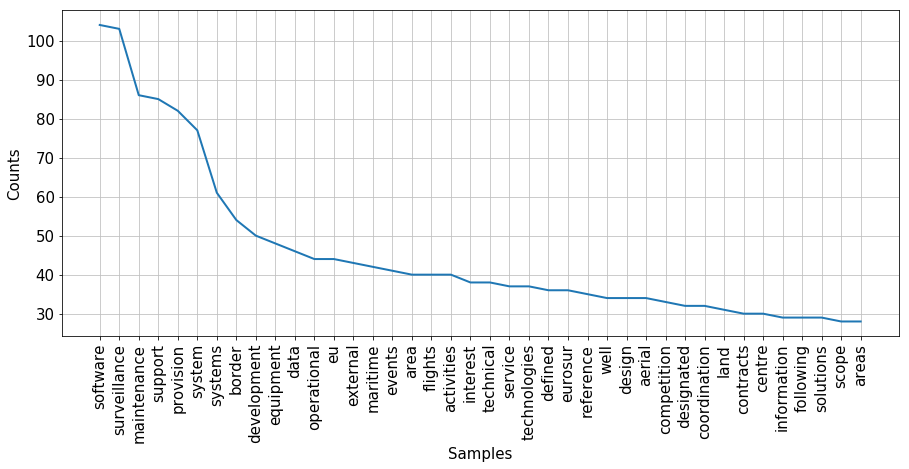

In [311]:
ignore_words = ["frontex", "lot", "lots", "contract", "tender", "ii", "services", "framework", "shall", "fwc", "contractor", "within", "provide", "associated", "may", "specific"]
fdist = nltk.probability.FreqDist([word for word in clean_words if word not in ignore_words])
fig = plt.figure(figsize = (15,6))
plt.rcParams.update({'font.size': 15})
fdist.plot(40)

# Getting contractor award counts from EXCL sheets

In [343]:
df1 = pd.read_excel(DATA_PATH + "/sheets/2019_AG.xlsx", engine='openpyxl')
df2 = pd.read_excel(DATA_PATH + "/sheets/2020_AG.xlsx", engine='openpyxl')
df3 = pd.read_excel(DATA_PATH + "/sheets/2021_AG.xlsx", engine='openpyxl')
df4 = pd.read_excel(DATA_PATH + "/sheets/2018_AG.xlsx", engine='openpyxl')
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

c:\users\mathias\appdata\local\programs\python\python36\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [344]:
frontex = df[df['Contracting Authority name'].str.contains('(?i)Border|Frontex')] # (?i) = ignore case

print(f"Number of records: {len(frontex)}")
print(f"Number of unique contractors: {len(frontex['Contractor awarded'].unique())}")
print(f"Total value of contracts: {frontex['Value of the Contract'].sum()}")

Number of records: 194
Number of unique contractors: 124
Total value of contracts: 1066255312.125


In [345]:
# Look for a keyword in all titles
keyword = 'Analysis'
res = frontex[frontex['Title of the notice'].str.contains(keyword).fillna(False)]['Title of the notice']
for key in res.keys():
    print(res[key])

Service Contract for the Provision of Social Media Analysis Services Concerning Irregular Migration Trends and Forecasts (as part of Pre-warning Mechanism)
Maritime Analysis Tools


In [346]:
# sometimes multiple companies are listed as a single contractor
combined_contractors = frontex['Contractor awarded'].unique()
print(f"n of combined contractors from sheets: {len(combined_contractors)}")
contractors = list(set([c for c_list in frontex['Contractor awarded'].unique() for c in c_list.split("---")]))
print(f"n of unique (split) contractors: {len(contractors)}")

n of combined contractors from sheets: 124
n of unique (split) contractors: 147


In [347]:
# manual mapping from different spellings of a company name to a single company tag
contractor_dict = {
    'EDISOFT-Empresa de Servicos e Desenvolvimento de Software, S.A.': 'edisoft',
    'Korporacja Wschód Sp. z o.o.' : 'Korporacja Wschód',
    'Pol-Mare Sp.Zo.o' : 'Pol-Mare',
    'Asseco Poland S.A.' : 'Asseco Poland',
    'ESRI Polska' : 'ESRI Polska',
    'TNT Express Worldwide (Poland) sp. z o.o.' : 'TNT Express',
    'Steinbeis 2I GMBH' : 'Steinbeis',
    'Cambridge School of English Sp. z o.o.' : 'Cambridge School of English',
    'FINCONS S.P.A. (Partner)' : 'FINCONS',
    'Bene Warszawa Sp ZOO' : 'Bene Warszawa',
    'Control system FMN Sp z oo': 'Control system FMN',
    'European Dynamics SA' : 'European Dynamics',
    'PWC — Pricewaterhousecoopers EU Services EESV' : 'PWC',
    'Ekotoi Ltd' : 'Ekotoi',
    'Fleischhacker GmbH and Co. KG' : 'Fleischhacker',
    'Carmenta AB' : 'Carmenta',
    'Mleasing Sp. z o.o.' : 'Mleasing',
    'Pecka Studio s.r.o.' : 'Pecka Studio',
    'Jarosław Sztobryn Prooffice' : 'Jarosław Sztobryn Prooffice',
    'Squire Patton Boggs Święcicki i Krześniak SP.K.' : 'Squire Patton Boggs',
    'Consortium ATOS POLSKA S.A. (leader)' : 'ATOS POLSKA',
    'Centro Informazione e Educazione Allo Sviluppo Onlus' : 'Centro Informazione e Educazione Allo Sviluppo Onlus',
    'CPD Systems SP. Z O.O.' : 'CPD Systems',
    'Optix SA' : 'Optix',
    'CNIM AIR SPACE SAS' : 'CNIM AIR SPACE',
    'Brill AV Media Sp z oo' : 'Brill AV Media',
    'Bird and Bird Szepietowski i Wspólnicy SP.K.' : 'Bird and Bird',
    'Intrasoft International S.A.' : 'Intrasoft International',
    'ISDEFE – Ingenieria Sistemas Para la Defensa de Espana' : 'ISDEFE',
    'Grafton Recruitment Sp z oo' : 'Grafton Recruitment',
    'Optexim AD' : 'Optexim',
    'Airbus DS Airborne Solutions GmbH' : 'Airbus',
    'e-GEOS SPA' : 'e-GEOS',
    'Pomilio Blumm SRL' : 'Pomilio Blumm',
    'Altia Consultores S.A.' : 'Altia Consultores',
    'Ricardo Nederland BV' : 'Ricardo',
    'Car Master 2 sp. z o.o. sp.k.' : 'Car Master 2',
    'Hawkeye 360, Inc.' : 'Hawkeye 360',
    'Solten France Societe a Responsabilite Limitee' : 'Solten',
    'Professional Aviation Solutions GmbH' : 'Professional Aviation Solutions',
    'Art’ Impression Catering Sp. z o.o.' : 'Art’ Impression Catering',
    'New Wave GmbH' : 'New Wave',
    'Kancelaria Radców Prawnych Cwik i Partnerzy SP.P.' : 'Kancelaria Radców Prawnych Cwik i Partnerzy',
    'Ricardo-AEA Ltd': 'Ricardo',
    'Ashurst LLP' : 'Ashurst',
    'Dat-Con d.o.o.' : 'Dat-Con',
    'Consortium of Oktagon Polska Paweł Toffel, AndRee GROUP Andrzej Toffel, ADART S.C. led by Oktagon Polska Paweł Toffel' : 'Oktagon Polska Paweł Toffel',
    'Maxi Cargo Sp.Zo.o' : 'Maxi Cargo',
    'Ingenieria De Sistemas Para La Defensa De Espana S.A., S.M.E., M.P.' : 'Ingenieria De Sistemas Para La Defensa De Espana',
    'Engineering Ingegneria Informatica S.P.A.' : 'Engineering Ingegneria Informatica',
    'European Dynamics Luxembourg SA' : 'European Dynamics',
    'Trasys International G.E.I.E.' : 'Trasys International',
    'DEA Aviation' : 'DEA Aviation',
    'Andree Group Andrzej Toffel' : 'Andree Group Andrzej Toffel',
    'IGEP SA/NV' : 'IGEP',
    'Ekotoi Ltd.' : 'Ekotoi',
    'ClanTect Ltd' : 'ClanTect',
    'eTravel SA' : 'eTravel',
    'JIT Team SP. Z O.O.' : 'JIT Team',
    'Softwin SRL' : 'Softwin',
    'Air Partner International GmbH' : 'Air Partner International',
    'Air Charter Service Limited' : 'Air Charter Service',
    'The Bridge – English Language Centre s.r.o.' : 'The Bridge',
    'GAF AG' : 'GAF',
    'Dom Volvo Car Sp. z o.o.' : 'Dom Volvo Car',
    'DEA Aviation Ltd' : 'DEA Aviation',
    'Sicurtransport' : 'Sicurtransport',
    'Hellenic Telecommunications Organization S.A. – OTE S.A. (Leader)' : 'Hellenic Telecommunications Organization',
    'Fly4Less Kft' : 'Fly4Less',
    'Air Charter Service Ltd' : 'Air Charter Service',
    'PricewaterhouseCoopers EU Services EESV' : 'PWC',
    'IN-innovative navigation GmbH' : 'IN-innovative navigation',
    'Air Charter Service GmbH' : 'Air Charter Service',
    'Israel Aerospace Industries Limited, Malat Division' : 'Israel Aerospace Industries',
    'PWC – Pricewaterhousecoopers EU Services EESV' : 'PWC',
    'City & Guilds of London Institute' : 'City & Guilds of London Institute',
    'Airborne Technologies GmbH' : 'Airborne Technologies',
    'SAS Institute Polska Sp. z o.o.' : 'SAS Institute',
    'Decuatro Marketing Promocional S.L.' : 'Decuatro Marketing Promocional',
    'Defacto Sp z oo' : 'Defacto',
    'Synergasia Cooperativa Sociale Onlus' : 'Synergasia Cooperativa Sociale Onlus',
    'EU Legis Avocats' : 'EU Legis Avocats',
    'Bird & Bird Szepietowski i Wspólnicy SP.K.' : 'Bird and Bird',
    'Pinpoint Corporate Services Ltd' : 'Pinpoint Corporate Services',
    'Deloitte — Deloitte Consulting and Advisory CVBA' : 'Deloitte',
    'in-innovative navigation GmbH' : 'IN-innovative navigation',
    'Miller Canfield W.Babicki, A.Chelchowski i Wspólnicy SP.K.' : 'Miller Canfield W.Babicki, A.Chelchowski i Wspólnicy',
    'DC System Company Sp z oo' : 'DC System Company',
    'ARHS Developments S.A.' : 'ARHS Developments',
    'EASP Air BV' : 'EASP Air',
    'Ekotoi Service Ltd' : 'Ekotoi',
    'Diamond-Executive Aviation Ltd' : 'Diamond-Executive Aviation',
    'Kaliszuk sp j staff partners' : 'Kaliszuk sp j staff partners',
    'Espes Office Sp ZOO' : 'Espes Office',
    'Outworking SA' : 'Outworking',
    'IDOM Consulting, Engineering and Architecture' : 'IDOM',
    'ZRB Walko Waldemar Koński' : 'ZRB Walko',
    'Instytut Systemów Bezpieczeństwa Sp. z o.o.' : 'Instytut Systemów Bezpieczeństwa',
    'Asseco Poland SA' : 'Asseco',
    'Daldewolf' : 'Daldewolf',
    'GMV Aerospace and Defence SAU' : 'GMV',
    'Telespazio France SAS' : 'Telespazio',
    'CAE Aviation' : 'CAE Aviation',
    'Elbit Systems Ltd, Advanced Technology Center' : 'Elbit Systems',
    'GMV Aerospace and Defence S.A.U.' : 'GMV',
    'Hogan Lovells (Warszawa) LLP (Spółka partnerska) Oddział w Polsce' : 'Hogan Lovells',
    'UNI Systems Information Technology Systems Commercial S.M.S.A. (Partner)' : 'UNI Systems',
    'OPTIX JSC' : 'Optix',
    'Seprotec Traduccion e Intepretacion Sociedad Limitada' : 'Seprotec',
    'Not awarded' : 'Not awarded',
    'UNI Systems Luxembourg S.a.r.l. (Partner)' : 'UNI Systems',
    'Leonardo SPA' : 'Leonardo',
    'Indra Sistemas SA' : 'Indra Sistemas',
    'Bechtle Brussels NV' : 'Bechtle',
    'Opticoelectron Group' : 'Opticoelectron Group',
    'PWC IT Services SP. Z O.O. (Partner)' : 'PWC',
    'Car Master 2 Sp. z o.o. Sp.k' : 'Car Master 2',
    'Avalon Tecnologías de la Información S.L.' : 'Avalon',
    'Lazaris A. Gomos D. OE' : 'Lazaris A. Gomos D.',
    'Nord Partner sp. z o.o.' : 'Nord Partner',
    'Jas Technologie Sp z oo' : 'Jas Technologie',
    'Soitron Group SE' : 'Soitron Group',
    'Robert Wagner — Wagner Werbemittel und Textilproduktion' : 'Robert Wagner',
    'Glassart S.A.' : 'Glassart',
    'Windward Ltd' : 'Windward',
    'TEKNE Srl' : 'TEKNE',
    'CAE Aviation Sarl' : 'CAE Aviation',
    'Sopra Steria Benelux SA/NV' : 'Sopra Steria',
    'ITBM LLC' : 'ITBM',
    'BHO Baumann, Heinrich, Ortner Rechtsanwalte und Patentanwalt Partnerschaft MBB' : 'BHO',
    'International SOS (Belgium) SPRL' : 'International SOS',
    'GI Group Sp z oo' : 'GI Group',
    'EPRD consortium – Office for Economic Policy and Regional Development' : 'EPRD consortium',
    'VISION BOX -SOLUCOES DE VISAO PORCOMPUTADOR SA' : 'VISION BOX',
    'Regula Baltija Ltd' : 'Regula Baltija',
    'EVERIS AEROESPACIAL Y DEFENSA SL' : 'EVERIS',
    'GTC AMG sp. z o.o.' : 'GTC AMG',
    'AS Aircontact' : 'Aircontact',
    'Atende SA' : 'Atende',
    'Computer Resources International S.A. (Partner)' : 'Computer Resources International',
    'Arlen S.A.' : 'Arlen',
    'PWC EU Services EESV (Leader)' : 'PWC',
    'Opticoelectron Group JSCo' : 'Opticoelectron Group',
    'Fabrity SP. Z O.O.' : 'Fabrity',
    'Accenture SP. Z O.O.' : 'Accenture',
    "ITC — Interpreti e Traduttori in Cooperativa Societa' Cooperativa" : 'ITC',
    'DSV Air and Sea Sp.Zo.o' : 'DSV'
}
unmapped_contractors = len([c for c in contractors if c not in contractor_dict])

# n of contracts awarded per contractor
contractor_counts = {}
for index, row in frontex.iterrows():
    split_contractors = row['Contractor awarded'].split("---")
    
    for contractor in split_contractors:
        tag = contractor_dict[contractor]
        
        if tag in contractor_counts:
            contractor_counts[tag] += 1
        else:
            contractor_counts[tag] = 1

<BarContainer object of 128 artists>

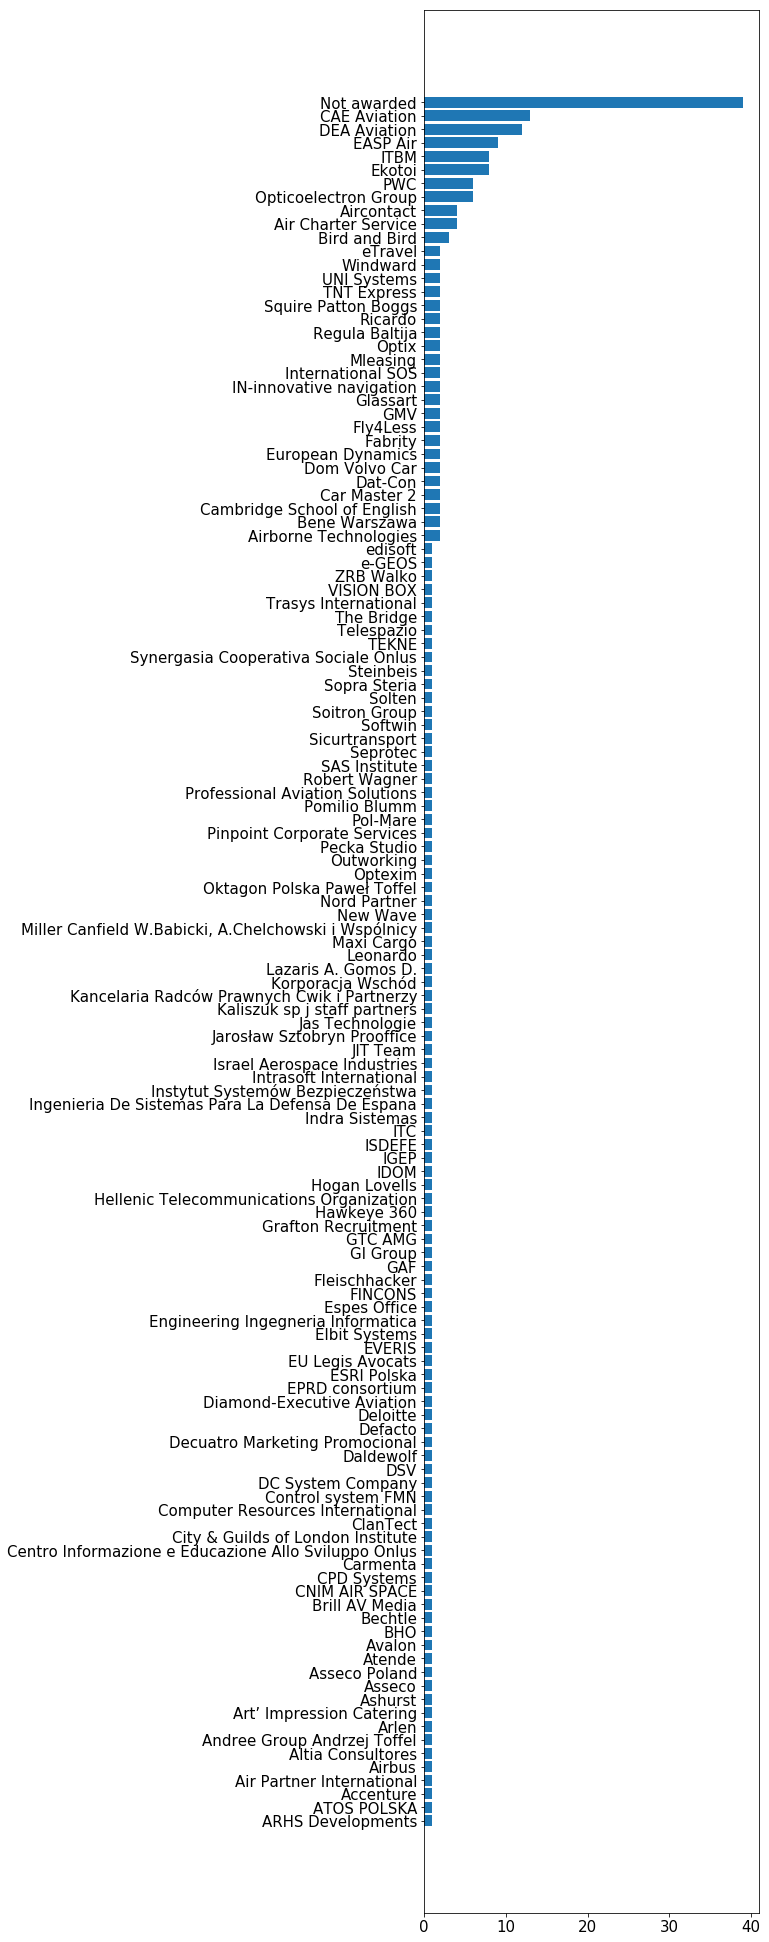

In [348]:
sorted_counts = sorted(zip(contractor_counts.values(), contractor_counts.keys()), reverse=False)[:]

fig = plt.figure(figsize = (6,35))
plt.barh([x for _,x in sorted_counts], [x for x,_ in sorted_counts])